<a href="https://colab.research.google.com/github/Eldave93/Seizure-Detection-Tutorials/blob/master/Classification_01_Feature_Pre_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Tutorial #01
# Feature Pre-Processing

by [David Luke Elliott](https://www.lancaster.ac.uk/psychology/about-us/people/david-elliott)
/ [GitHub](https://github.com/Eldave93) 

In this notebook we will explore how to prepare a dataset so it can be used for classification. We will cover the concepts of splitting data into test and training sets, scaling the data values so they are comparable, and balancing the classes so there is not an uneven distribution of data belonging to each class.

In [0]:
# need at least 0.9.0
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


# Data Preparation

First lets start by getting our workspace ready and then loading in the data.

In [0]:
import os                         # for file locations
import matplotlib.pyplot as plt   # for plotting

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Lets start by loading in the feature dataframe we made in the first Feature Extraction Tutorial (Epileptologie). If you do not have the dataframe already created then go to that previous tutorial and click run all (it sould take less than a minute). 

If you are using Google Colab for both notebooks it should now be in your Files and you can continue with this tutorial if you like. If you saved the file locally onto your computer then go into the left tab, Files, and upload the data. 

If you saved it into Google Drive then you can mount the drive as shown below

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Now lets put the data into a pandas dataframe and have a quick reminder of its structure.

This dataset has only one signal that was divided into multipule datasets lasting 23.6 seconds each. Each dataset was associated with a class and had features extracted from it. These briefly were:

**Welch**

The Welch method is a spectral density estimation method that calculates a periodogram for windowed sections of data using a Fourier Transform. Overlapping segments are windowed with a discrete Fourier tranform applied to calculate the periodogram which is then squared and averaged to get a power measure.
- *power_delta*: Average power between 0.1hz and 4hz 
- *power_theta*: Average power between 4hz and 8hz 
- *power_alpha*: Average power between 8hz and 12hz 
- *power_beta*: Average power between 12hz and 30hz 
- *power_gamma*: Average power between 30hz and 70hz 

**Discrete Wavelet Transform**

Several oscillatory kernel-based wavelets are stretched and moved to different positions in time across a signal, dividing the data into different frequency components which are each analysed in respect to their scale.
- *LSWT*: The log-sum energy of the subband coefficients
- *mean*: Average power of the wavelet coefficients in each sub-band
- *mean_abs*: Mean of the absolute values of the coefficients in each sub-band
- *std*: Standard deviation of the coefficients in each sub-band
- *Ratio*: Ratio of the absolute mean values of adjacent sub-bands

If you want more specific detail on these features then I recommend you look at the tutorial associated with the feature extraction.

In [0]:
FILE_PATH = 'feature_df.json.gzip'

In [0]:
import numpy as np
import pickle           # saving python objects
import pandas as pd     # dataframes

# load features dataframe
feature_df = pd.read_json(FILE_PATH, orient='index', compression = 'gzip')

# display examples of the data
display(feature_df.info())
display(feature_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 99
Data columns (total 38 columns):
D1_LSWT        500 non-null float64
D1_Ratio       500 non-null float64
D1_mean        500 non-null float64
D1_mean_abs    500 non-null float64
D1_std         500 non-null float64
D2_LSWT        500 non-null float64
D2_Ratio       500 non-null float64
D2_mean        500 non-null float64
D2_mean_abs    500 non-null float64
D2_std         500 non-null float64
D3_LSWT        500 non-null float64
D3_Ratio       500 non-null float64
D3_mean        500 non-null float64
D3_mean_abs    500 non-null float64
D3_std         500 non-null float64
D4_LSWT        500 non-null float64
D4_Ratio       500 non-null float64
D4_mean        500 non-null float64
D4_mean_abs    500 non-null float64
D4_std         500 non-null float64
D5_LSWT        500 non-null float64
D5_Ratio       500 non-null float64
D5_mean        500 non-null float64
D5_mean_abs    500 non-null float64
D5_std         500 non-null floa

None

,D1_LSWT,D1_Ratio,D1_mean,D1_mean_abs,D1_std,D2_LSWT,D2_Ratio,D2_mean,D2_mean_abs,D2_std,...,D6_mean_abs,D6_std,class,file_id,location,power_alpha,power_beta,power_delta,power_gamma,power_theta
0,3.665018,0.362810,-0.041443,1.910710,2.479649,4.749819,0.631333,-0.008293,5.266416,6.528848,...,76.722313,95.640549,baseline,F001,intracranial epileptogenic zone,13.102026,4.033713,125.389091,1.101212,38.175072
1,8.020356,0.208105,-0.002805,1.761159,3.013578,8.062119,0.514802,0.120496,8.462824,18.706007,...,281.597393,402.092208,baseline,F002,intracranial epileptogenic zone,201.886582,52.737781,3797.194021,14.147616,492.166476
10,6.515312,0.311432,-0.010631,1.735392,2.990964,6.401762,0.507149,-0.091654,5.572303,8.469864,...,235.040525,300.746687,baseline,F011,intracranial epileptogenic zone,63.214856,13.262137,508.088808,3.541412,232.580771
100,6.521874,0.281573,0.028450,1.568284,2.040836,6.376845,0.493431,-0.032461,5.569725,7.127406,...,148.876959,202.647982,baseline,N001,intracranial hippocampus,52.397931,10.942102,495.788894,2.875845,177.343160
101,7.982971,0.265519,-0.087572,2.132034,2.816778,8.089832,0.590290,0.146568,8.029698,10.746922,...,170.622285,224.289541,baseline,N002,intracranial hippocampus,83.752534,18.473806,1045.280725,4.979004,289.653871


# Splitting Data

We need to split the data up into an array containing the feature data and an array of the class labels.

However before diving in, lets first take a moment to reflect on scikit-learn's design principles<sup>1</sup>, as laid out by Géron (2017)<sup>2</sup>, so we can get an understanding as to how to use scikit-learn's API:

- Consistency 
    - *Estimators*: Objects that can estimate parameters based on a dataset. Estimation is performed by the *fit()* method that takes a dataset (or two for supervised learning), with other parameters being hyperparameters set via an instance variable.
    - *Transformers*: Some estimators (e.g. LabelEncoder) can transform the dataset using a *transform()* method to return the transformed dataset; with a convinient and sometimes optimised *fit_transform()* method to do both.
    - *Predictors*: Some estimators can make predictions using a *predict()* method, which can be measured for quality using the *score()* method.
- Inspection
    - All hyperparameters are available by instance variables (e.g. LogisticRegressionObject.C) and all learned parameters accessible with underscore instance variables (e.g. LogisticRegressionObject.intercept_)
- Nonproliferation of classes
    - Datasets are NumPy arrays or SciPy sparse matrices with hyperparameters Python strings or numbers.
- Composition
    - Bulding blocks can be re-used as much as possible; for example the use of *Pipeline* tostring together transformers and an estimator
- Sensible defaults
     - Most parameters have sensible defaults to get a baseline system working quickly
     
**NOTE**
- We will be focusing on *Estimators* and *Transformers* in this notebook, with *Predictors* found in the following tutorial
- If you look at the number of epoch labels (seconds) you will notice there is a class imballance, we will come to this later.


---

1. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
2. Buitinck, L., Louppe, G., Blondel, M., Pedregosa, F., Mueller, A., Grisel, O., ... & Layton, R. (2013). API design for machine learning software: experiences from the scikit-learn project. arXiv preprint arXiv:1309.0238.

In [0]:
import sklearn
sklearn.__version__

'0.20.3'

## Datax

Getting the feature array is pretty easy. All we need do is remove the other columns referring to the class, file_id and location of the electrodes as these will not be used to help classify the signals.

Scikit-learn accepts numpy arrays so we need to change our pandas dataframe to an array. This is simple enough as we just need to use `.values`

In [0]:
feature_df_drop = feature_df.drop(['class', 'file_id', 'location'], axis='columns')
data_x = feature_df_drop.values

data_x

array([[ 3.66501809e+00,  3.62810293e-01, -4.14425738e-02, ...,
         1.25389091e+02,  1.10121248e+00,  3.81750719e+01],
       [ 8.02035555e+00,  2.08105398e-01, -2.80485050e-03, ...,
         3.79719402e+03,  1.41476156e+01,  4.92166476e+02],
       [ 6.51531181e+00,  3.11431757e-01, -1.06305493e-02, ...,
         5.08088808e+02,  3.54141231e+00,  2.32580771e+02],
       ...,
       [ 7.35772905e+00,  2.29384153e-01, -1.57318866e-02, ...,
         1.14003130e+03,  6.67119011e+00,  4.18564955e+02],
       [ 5.54178638e+00,  3.81416637e-01,  5.22557040e-03, ...,
         9.44539717e+01,  1.16654290e+00,  5.58108115e+01],
       [ 6.91707934e+00,  4.01009836e-01,  2.78221608e-02, ...,
         1.19770925e+02,  1.48362589e+00,  6.65889375e+01]])

## Datay

Getting the class labels ready has a little more to it as you need to make a decision regarding how you encode it. Data class strings are typically encoded into integers, using methods such as one-hot encoding, dummy coding and effect coding.

The most simple method is to use a label encoder, which encodes labels with value between 0 and n_classes-1. However values then become orderable, which should not be permissible for destinct categories<sup>1</sup>. Still this is a common and easy method because it is easy to get sklearn to fit and predict models based on integer encoded data.

Lets have a look at how we could encode the class labels to make a binary decision, seizure or no seizure.

**NOTE**
- The positive class in scikit-learn is the class that is labeled as class 1 unless specified when creating a scoring metric.

---

1. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".

In [0]:
display(feature_df['class'].value_counts())

baseline    400
seizure     100
Name: class, dtype: int64

In [0]:
from sklearn.preprocessing import LabelEncoder

# create condition(group) array
class_series = feature_df['class']

# make a label encoder
le = LabelEncoder()
# change the string labels to ints
data_y = le.fit_transform(class_series)

# get the unique labels
labels = list(class_series.unique())
# print out the labels and their new codes
for i, code in enumerate(list(le.transform(labels))):
    print(labels[i] + ': ' + str(code))
    
data_y[:5]

baseline: 0
seizure: 1


array([0, 0, 0, 0, 0])

Another method is to use One-Hot Encoding which represents category labels as a group of bits with each bit representing a category. However this method uses one more bit than really neccissary, leading to a linear dependency (e1 + e2 + ... + ek = 1).

Imagine we wanted to classify the locations of the electrodes, as we have 3 locations, then to ensure class 2, 1, 0 are not given different weights then we should encode them using the LabelBinarizer.

**Note** 
- a one-hot encoding of y labels should use LabelBinarizer instead of the OneHotEncoder as the latter is meant for feature variables NOT classes

In [0]:
feature_df['location'].value_counts()

intracranial epileptogenic zone    200
surface                            200
intracranial hippocampus           100
Name: location, dtype: int64

**Note**
- SciPy sparse matrices are useful for one-hot encoded data as it only stores the location of the nonzero elements so saves on space. These are the default for sklearn.preprocessing.OneHotEncoder and can be used where you want to use categorical data as a feature.

In [0]:
from sklearn.preprocessing import LabelBinarizer

# create condition(group) array
location_series = feature_df['location']

# make a label encoder
lb = LabelBinarizer()
# change the string labels to ints
data_y = lb.fit_transform(location_series)

# get the unique labels
labels = list(location_series.unique())
# print out the labels and their new codes
for i, code in enumerate(list(lb.transform(labels))):
    print(labels[i] + ': ' + str(code))
    
data_y[:5]

intracranial epileptogenic zone: [1 0 0]
intracranial hippocampus: [0 1 0]
surface: [0 0 1]


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]])

Dummy Coding avoids the latter problem with One-Hot Encoding, as it represents features in only k-1 features. The last feature is represented by all 0's and known as the reference category. However this means, unlike one-hot encoding, missing data cannot be represented as all 0's.

There doesnt appear at time of writing a way to do this in sklearn, but we can do it easily in Pandas using the get_dummies function. By default, the get_dummies() does not do dummy encoding, but one-hot encoding, so we need to use drop_first=True (notice from the pandas df there is no intracranial epileptogenic zone as it is now [0,0]).

In [0]:
one_hot_y = pd.get_dummies(location_series)
dummy_y = pd.get_dummies(location_series, drop_first=True)

print(color.BOLD+color.UNDERLINE+'Onehot'+color.END)
display(one_hot_y.head())
print(color.BOLD+color.UNDERLINE+'Dummy'+color.END)
display(dummy_y.head())

data_y = dummy_y.values

data_y[:5]

Onehot


,intracranial epileptogenic zone,intracranial hippocampus,surface
0,1,0,0
1,1,0,0
10,1,0,0
100,0,1,0
101,0,1,0


Dummy


,intracranial hippocampus,surface
0,0,0
1,0,0
10,0,0
100,1,0
101,1,0


array([[0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

There are other methods that we won't focus upon but I will briefly mention them.

Firstly there is effect coding, which is similar to dummy coding except the reference category is represented as -1's rather than two 0's. The reason you may want to do this relates to interpretaion of a regression analysis, which we will not touch on in this notebook, however can be read about in Zheng and Casari (2018)<sup>1</sup>.

For large categorical variables, feature hashing can be used. A hash function deterministically maps unbounded integers to a finite range with multipule numbers mapped to the same output (collision). Uniform hashing means roughly the same number of numbers are mapped to each m bins. However the problem is that hashed features are no longer interpretable, but do have major computational benifits for data exploration and viualization in machine learning for large datasets.

Bin counting is another method for large data that uses the conditional probability of a target rather than the category value. It assumes that historical data is availible for the statistics. Other features can be used in additional probability including raw counts and the log-odds ratio. This is in order to convert a large, sparse binary categorical representation into small, dense, real-valued numbers. Rare categories can also be given their own bin, if under a threshold, as these categories likely will not provide enough data to reliably estimate the given target. The problem with bin counting is there is potential for data leakage, although there are methods to prevent this<sup>1</sup>.

---
1. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".

## Training and Test Data

Data is split into training and test sets that have the same class proportions as the original data. This is because later when we fit out classification model to predict a class in the data, we want to compare predictions to some true labels in a separate group of data (the test set) to give an unbiased performance evaluation of our model before we use it in the real world. Balancing the information loss in the training set and estimation of a models generalization error requires the size of the data to be taken into consideration. As we are witholding data the algorithm could learn from for the test set we don't want to withhold too much information but the smaller the test set, the more inaccurate the estimation of the generalization error<sup>1</sup>.

To split the data we will use the train_test_split function. Note that this function automatically shuffles the data before splitting. We fix a random_state parameter, as we will for a number of later functions, to fix the internal pseudo-random number generator used for shuffling the datasets to ensure our results are reproducible.

Lets start by going back to a simple label encoded y data to encode seizure and non-seizure data and we will remove the surface electrodes.

**NOTE**
- Its advised you actually split the data before calculating your features to ensure they are separated. However, for the ease of this tutorial we worked out all the features first and are splitting them now

---

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

In [0]:
# select only intracranial EEG
feature_reduced = feature_df[feature_df.location != 'surface']
# drop the columns which are not feature variables
feature_reduced_drop = feature_reduced.drop(['class', 'file_id', 'location'], axis='columns')
# change to an array
data_x = feature_reduced_drop.values
# change the string labels to ints
data_y = le.fit_transform(feature_reduced['class'])

print(color.BOLD+'Feature DataFrame'+color.END)
display(data_x.shape)
print(color.BOLD+'Target DataFrame'+color.END)
display(data_y.shape)

Feature DataFrame


(300, 35)

Target DataFrame


(300,)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=0)

print(color.BOLD+color.UNDERLINE+'Feature DataFrame'+color.END)
print('Training size: ' + str(X_train.shape))
print('Test size: ' + str(X_test.shape))
print(color.BOLD+color.UNDERLINE+'\nTarget DataFrame'+color.END)
print('Training size: ' + str(y_train.shape))
print('Test size: ' + str(y_test.shape))

Feature DataFrame
Training size: (240, 35)
Test size: (60, 35)

Target DataFrame
Training size: (240,)
Test size: (60,)


Lets just check that the proportions of a class membership is in the split data (1st column being class label and 2nd being count)

In [0]:
print(color.BOLD+color.UNDERLINE+'Feature DataFrame'+color.END)
display(np.array(np.unique(y_train, return_counts=True)).T)
print(color.BOLD+color.UNDERLINE+'\nTarget DataFrame'+color.END)
display(np.array(np.unique(y_test, return_counts=True)).T)

Feature DataFrame


array([[  0, 160],
       [  1,  80]])


Target DataFrame


array([[ 0, 40],
       [ 1, 20]])

# Scaling

Scaling the features is important for most classifiers, except decision trees and random forests (we will talk about them in the next notebook). 

There are two general methods to scaling we will discuss; normalisation and standardization.

Normalisation converts signals into a common range so they can be compared, through detrending the signal by removing the mean or scaling to a unit variance to a range of 0-1 using methods such as min-max scaling. The mean of a single electrode recording depends on the amplifier gain, so normalisation is particularly required if comparing signals from different recording equipment or researchers.

Standardization is similar, but centres the feature columns at mean 0 with standard deviation 1 so that the features form a normal distribution. This is particularly useful for classifiers that use optimization algorithms, such as logistic regression and SVM, as it makes it easier for the model to learn weights and makes the algorithm less sensitive to outliers than min-max scaling<sup>1</sup>.

**TODO**
- find where I got the placeholder from, probs Varsavsky but check because useful to compare with standardization

**References**

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mms = MinMaxScaler()
X_train_mms = mms.fit_transform(X_train)

sc = StandardScaler()
X_train_scale = sc.fit_transform(X_train)

print(color.BOLD+color.UNDERLINE+'Before Scaling'+color.END)
display(X_train[:5,0])
print(color.BOLD+color.UNDERLINE+'After MinMaxScaler'+color.END)
display(X_train_mms[:5,0])
print(color.BOLD+color.UNDERLINE+'After StandardScaler'+color.END)
display(X_train_scale[:5,0])

Before Scaling


array([9.15723852, 7.41718324, 7.27105171, 6.78431982, 4.57989131])

After MinMaxScaler


array([0.83258458, 0.67437715, 0.66109073, 0.61683662, 0.41640795])

After StandardScaler


array([ 1.18186951,  0.22545493,  0.14513431, -0.12239597, -1.33405147])

# Balancing the Classes

In some domain applications, the data will have a differing number of data in each class. This is particularly the case in seizure detection, where seizures ('Ictal' EEG) happen infrequently comparative to baseline EEG (known as Interictal - the period between seizures). The learning and prediction of machine learning algorithms tend to be affected by imballances; for example the decision function of a linear SVM may favour the majority class<sup>1</sup>. There are a number of methods available to address imbalances in a dataset, with types being broadly categorised into Under-Sampling, Over-Sampling, and a combination of both.

However before getting into the method, first lets look at our data and pick two features to visualise for the re-sampling because as can be seen below there are loads of combinations!

**NOTE**
- this is a pretty quick tour of ballancing methods. For more in-depth explanations make sure to check out: https://github.com/scikit-learn-contrib/imbalanced-learn

---

1. http://contrib.scikit-learn.org/imbalanced-learn/stable/introduction.html

In [0]:
import seaborn
import seaborn as sns; sns.set(color_codes=True)

seaborn.__version__

'0.9.0'

**NOTE**
- Below is quite computationally expensive so if the image already exists load that in rather than calculate it again!

In [0]:
%%time
from IPython.display import Image

SKIP=True
SCATTER_PLOT_PATH = 'tutorial_scatterplot_matrix.png'

# if the image already exists
if os.path.exists(SCATTER_PLOT_PATH):
    display(Image(SCATTER_PLOT_PATH))

elif SKIP==False:
    # make a dataframe out of the sclaed training set
    plot_data = pd.DataFrame(X_train_scale, columns = feature_reduced_drop.columns)
    # make a class column the training clas set which has changed from integers to strings
    plot_data['class'] = np.vectorize({0:'Baseline', 1:'Seizure'}.get)(y_train)
    # plot each feature against each other with the classes used to separate out data
    sns.pairplot(plot_data, height =2.5, hue = 'class', markers=["o", "s"])
    plt.savefig(SCATTER_PLOT_PATH, dpi=300)
    plt.show()

CPU times: user 615 µs, sys: 66 µs, total: 681 µs
Wall time: 608 µs


Now lets pick two features to plot against each other, so below are all the options.

In [0]:
feature_list = list(feature_reduced_drop.columns)
feature_list

['D1_LSWT',
 'D1_Ratio',
 'D1_mean',
 'D1_mean_abs',
 'D1_std',
 'D2_LSWT',
 'D2_Ratio',
 'D2_mean',
 'D2_mean_abs',
 'D2_std',
 'D3_LSWT',
 'D3_Ratio',
 'D3_mean',
 'D3_mean_abs',
 'D3_std',
 'D4_LSWT',
 'D4_Ratio',
 'D4_mean',
 'D4_mean_abs',
 'D4_std',
 'D5_LSWT',
 'D5_Ratio',
 'D5_mean',
 'D5_mean_abs',
 'D5_std',
 'D6_LSWT',
 'D6_Ratio',
 'D6_mean',
 'D6_mean_abs',
 'D6_std',
 'power_alpha',
 'power_beta',
 'power_delta',
 'power_gamma',
 'power_theta']

Now we pick our two options and we'll format the df so they are put in two side by side columns

In [0]:
x_axis_label = 'D1_Ratio'
y_axis_label = 'D2_Ratio'

reduced_array = X_train_scale[:,[feature_list.index(x_axis_label),feature_list.index(y_axis_label)]]
reduced_df = pd.DataFrame(reduced_array, columns=[x_axis_label, y_axis_label])

reduced_df.head()

,D1_Ratio,D2_Ratio
0,-1.478335,0.984081
1,-0.921590,-0.937015
2,1.056602,0.637656
3,0.027368,0.290727
4,0.919145,0.605780


Now we can look at that pairplot

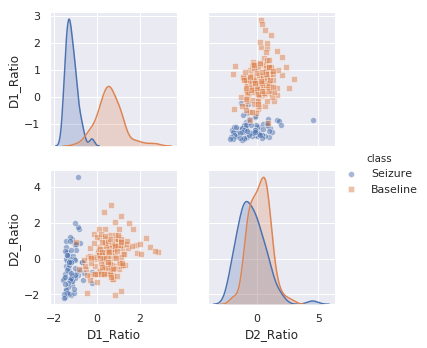

In [0]:
def plot_pairplot(data_x, data_y):

    data_plot = data_x.copy()
    data_plot['class'] = np.vectorize({0:'Baseline', 1:'Seizure'}.get)(data_y)
    sns.pairplot(data_plot, 
                 hue = 'class', 
                 markers=["o", "s"], 
                 plot_kws=dict(alpha = 0.5))
    plt.show()
    
plot_pairplot(reduced_df, y_train)

## Under-Sampling

### Resample

A fast way to balance the data is just to randomly select a subset of the data for each class so they have the number of datapoints found in the smallest class.

First lets do this using the scikit-learn library

Before Resample
Counter({0: 160, 1: 80})
After Resample
Counter({1: 80, 0: 80})


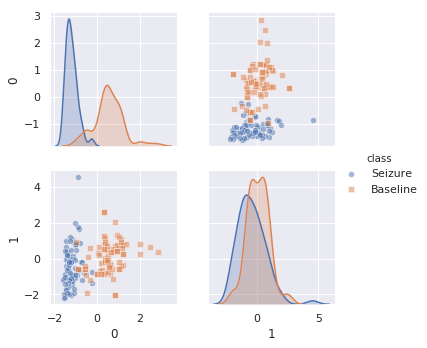

In [0]:
from sklearn.utils import resample
from collections import Counter

print(color.UNDERLINE + 'Before Resample' + color.END)
print(Counter(y_train))

data_x_downsampled, data_y_downsampled = resample(reduced_df[y_train == 0],
                                                  y_train[y_train == 0],
                                                  replace=True,
                                                  n_samples=reduced_df[y_train == 1].shape[0],
                                                  random_state=123)

data_x_bal = np.vstack((reduced_df[y_train == 1], data_x_downsampled))
data_y_bal = np.hstack((y_train[y_train == 1], data_y_downsampled))

print(color.UNDERLINE + 'After Resample' + color.END)
print(Counter(data_y_bal))

plot_pairplot(pd.DataFrame(data_x_bal), pd.DataFrame(data_y_bal))

### RandomUnderSampler

RandomUnderSampler is part of the Imblearn package, which allows for a lot of techniques for working with imballanced data.

First we'll look at how you can do a random undersample with this package, which is just an easier version of what we have just done

Before Resample
Counter({0: 160, 1: 80})
After Resample
Counter({0: 80, 1: 80})


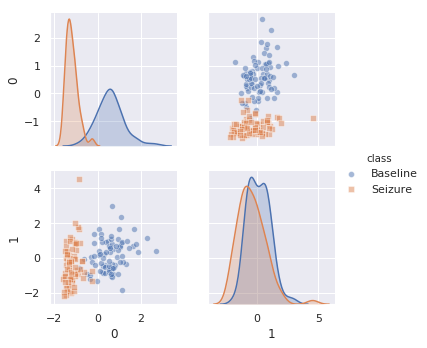

In [0]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def imblearn_sample(sampler, data_x, data_y):

    print(color.UNDERLINE + 'Before Resample' + color.END)
    print(Counter(data_y))

    data_x_downsampled, data_y_downsampled = sampler.fit_resample(data_x,
                                                                  data_y)

    print(color.UNDERLINE + 'After Resample' + color.END)
    print(Counter(data_y_downsampled))

    plot_pairplot(pd.DataFrame(data_x_downsampled), pd.DataFrame(data_y_downsampled))
    
imblearn_sample(RandomUnderSampler(random_state=123), reduced_df, y_train)

### NearMiss

A number of undersampling methods use heuristics based on k-nearest neighbors (KNN) classification<sup>1</sup>. KNN finds a number of samples that are the most similar to a data point we want to classify, based on a given distance metric, with its assigned class label depending on a majority vote by the nearest neighbours<sup>2</sup>. NearMiss uses this by selecting samples in the class to be under-sampled where the average distance to the closest or farthest samples of the minority class is smallest<sup>3</sup>. 

**References**
1. Mani, I., & Zhang, I. (2003, August). kNN approach to unbalanced data distributions: a case study involving information extraction. In Proceedings of workshop on learning from imbalanced datasets (Vol. 126).
2. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
3. Lemaître, G., Nogueira, F., & Aridas, C. K. (2017). Imbalanced-learn: A python toolbox to tackle the curse of imbalanced datasets in machine learning. The Journal of Machine Learning Research, 18(1), 559-563.

Before Resample
Counter({0: 160, 1: 80})
After Resample
Counter({0: 80, 1: 80})


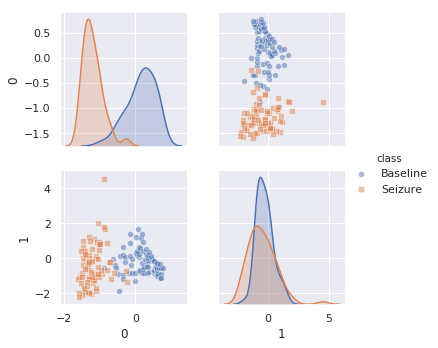

In [0]:
from imblearn.under_sampling import NearMiss

imblearn_sample(NearMiss(random_state=123), reduced_df, y_train)

### NeighbourhoodCleaningRule

Undersampling techniques also include data cleaning rules, where the number of samples in classes are not specified, but data is edited based on methods such as removing data dissimilar to their neighbourhood<sup>1</sup> or by removing one or both samples in different classes when they are nearest neighbors of each other<sup>2</sup>.

---
1. Wilson, D. L. (1972). Asymptotic properties of nearest neighbor rules using edited data. IEEE Transactions on Systems, Man, and Cybernetics, (3), 408-421.
2. Tomek, I. (1976). Two modifications of CNN. IEEE Trans. Systems, Man and Cybernetics, 6, 769-772.

Before Resample
Counter({0: 160, 1: 80})
After Resample
Counter({0: 146, 1: 80})


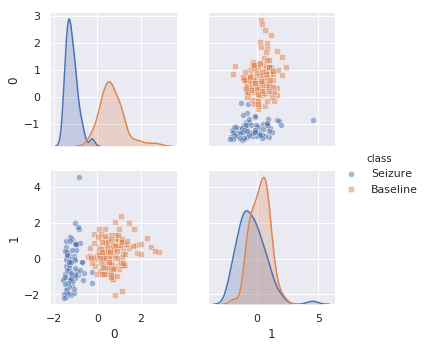

In [0]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

imblearn_sample(NeighbourhoodCleaningRule(random_state=123), reduced_df, y_train)

## Over-Sampling

### RandomOverSampler
Data can be oversampled easily by randomly sampling from minority classes with replacement to duplicate original samples. 

**Notes**
- make sure to oversample after splitting the training and validation sets or you may "bleed" information into the validation sets of the model when trying to test a model (https://beckernick.github.io/oversampling-modeling/)

Before Resample
Counter({0: 160, 1: 80})
After Resample
Counter({1: 160, 0: 160})


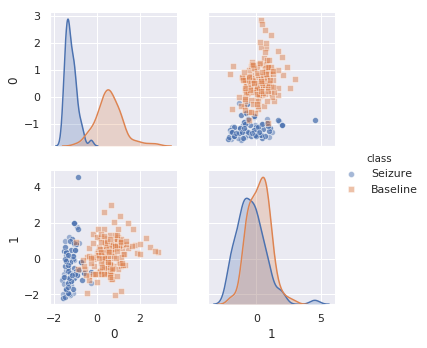

In [0]:
from imblearn.over_sampling import RandomOverSampler

imblearn_sample(RandomOverSampler(random_state=123), reduced_df, y_train)

### ADASYN and  SMOTE
Instead of just randomly oversampling there are also available approaches that generate new samples through the use of interpolation, such as SMOTE and ADASYN. However these methods can generate noisy samples so the previously discussed cleaning methods can be applied after oversampling<sup>1</sup>.

---
1. Batista, G. E., Prati, R. C., & Monard, M. C. (2004). A study of the behavior of several methods for balancing machine learning training data. ACM SIGKDD explorations newsletter, 6(1), 20-29.

SMOTE
Before Resample
Counter({0: 160, 1: 80})
After Resample
Counter({1: 160, 0: 160})


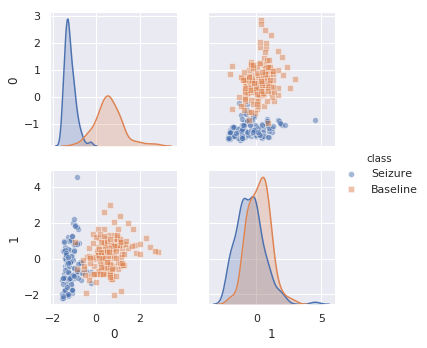

ADASYN
Before Resample
Counter({0: 160, 1: 80})
After Resample
Counter({0: 160, 1: 157})


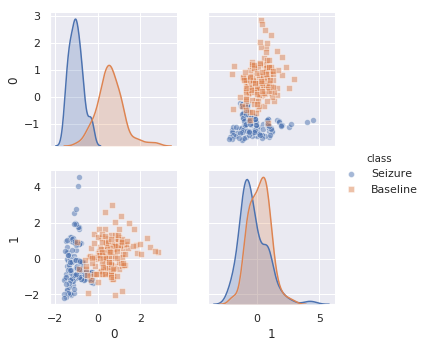

SMOTE with Edited Nearest Neighbor
Before Resample
Counter({0: 160, 1: 80})
After Resample
Counter({0: 149, 1: 148})


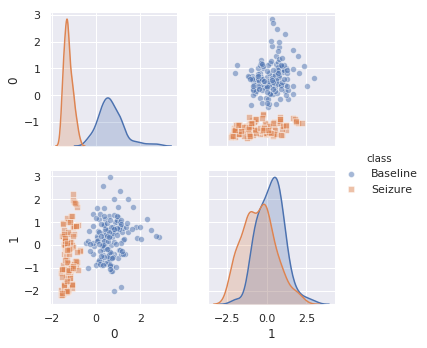

SMOTE with Tomek links
Before Resample
Counter({0: 160, 1: 80})
After Resample
Counter({1: 158, 0: 158})


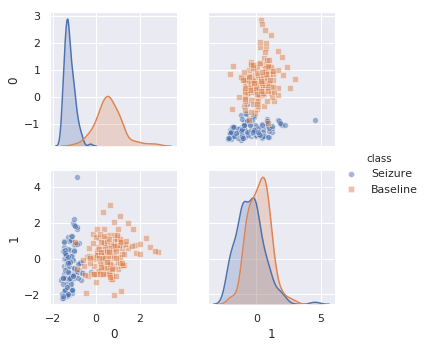

In [0]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

print(color.BOLD+color.UNDERLINE+'SMOTE'+color.END)
imblearn_sample(SMOTE(random_state=123), reduced_df, y_train)
print(color.BOLD+color.UNDERLINE+'ADASYN'+color.END)
imblearn_sample(ADASYN(random_state=123), reduced_df, y_train)
print(color.BOLD+color.UNDERLINE+'SMOTE with Edited Nearest Neighbor'+color.END)
imblearn_sample(SMOTEENN(random_state=123), reduced_df, y_train)
print(color.BOLD+color.UNDERLINE+'SMOTE with Tomek links'+color.END)
imblearn_sample(SMOTETomek(random_state=123), reduced_df, y_train)

# Exercises

Below are a few suggested exercises that may help improve your skills.

**TODO**
- Make some exercises...

# License

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.